<a href="https://colab.research.google.com/github/sizentsova/testing/blob/main/scplants_practical_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
### 💬 _ABOUT THIS NOTEBOOK_
When you open this Google Colab notebook, it allocates a Virtual Machine (VM) that you can use to execute the code blocks below. When you reach a code block, click the \[▶\] button to run it in the VM. Make sure you run the blocks in the order they appear, or you could run into errors!
___

# **Single Cell Transcriptomics: From Reads to Counts**

There are many ways to sequence RNA from single cells, and not all methods produce the same information!
In this notebook we are going to take a closer look at the raw sequencing output from two different single-cell protocols: the 10X Genomics Chromium platform, and Smart-seq2. Both were used by [Lopez-Anido et al.](https://www.sciencedirect.com/science/article/pii/S1534580721002112) to produce their single-cell atlas of leaf development, and specifically the meristemoid lineage that generates guard cells:

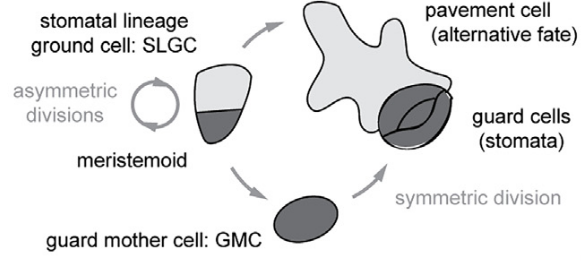

We won't be processing the full dataset today ([GSE167135](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE167135), over 1.3 billion reads in total), but I've chosen a few cells from the collection that we can analyze. These cells were sorted using a fluorescent reporter for the leaf meristemoid marker _TOO MANY MOUTHS (TMM)_ and show the development of guard cells from their undifferentiated precursors. The full dataset integrates five pooled scRNA-seq experiments (3 pools of 10X Genomics v3, 12,933 cells; 2 pools of Smart-seq2, 478 cells). Here is what the full dataset looks like (from Figure S4):

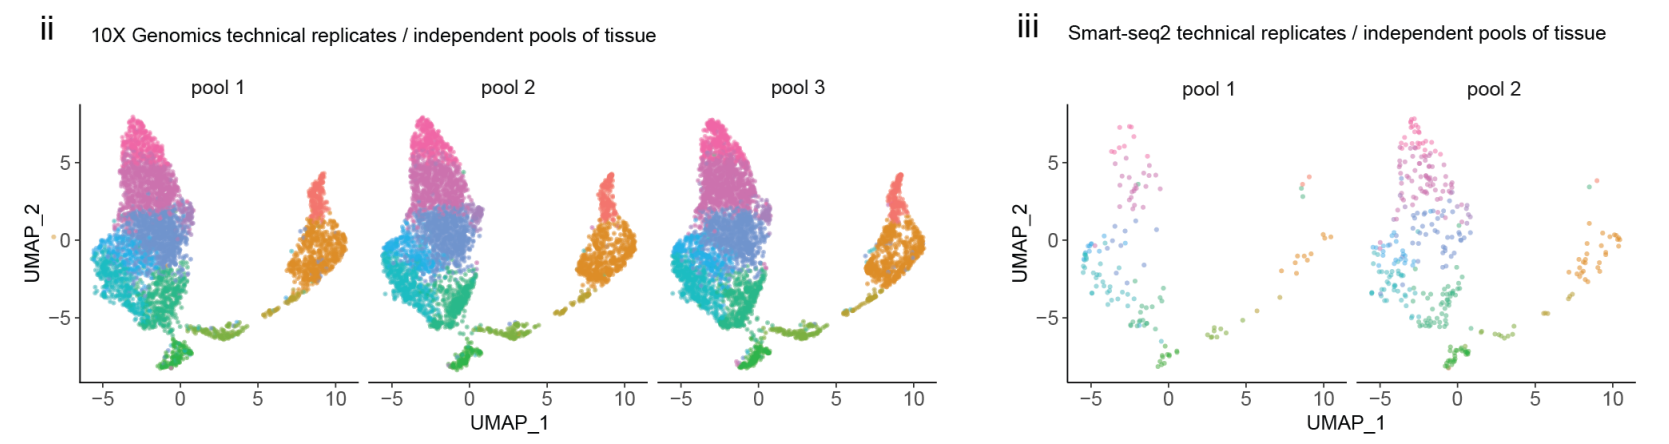

Instead of trying to look at thousands of cells at once, we will be looking at four (two from each method) to get a better understanding of the data hiding behind the dots. Specifically, I chose two 10X cells and two Smart-seq2 cells from the committed Guard Mother Cell (GMC) cluster, which we expect to express the transcription factors _SPEECHLESS_ (AT5G53210) and _MUTE_ (AT3G06120) in addition to _TMM_ (AT1G80080).


___
# 1. Download Software and Datasets
We will start by importing our resources from [this GitHub repository](https://github.com/maschon0/scPlants_practical0). Click the play icon to initialize the VM and install everything. This can take a few minutes, so while you are waiting you can browse through the GitHub page to see what files you are downloading.

In [ ]:
# Download and enter the GitHub repo
!git clone https://github.com/maschon0/scPlants_practical0
%cd scPlants_practical0
# Executable permissions so the notebook can run STAR and samtools
!chmod +x software/STAR
!chmod +x software/samtools
# Uncompress the resource files
!gunzip resources/*
# Download Python packages
!pip install deeptools
from IPython.display import Image

___
💬 Let's take a quick look at the data that we just imported:

In [ ]:
# Show the first 2 reads of each FASTQ file
!printf "### Smart-seq2 cell 1:\n"
!gunzip -c resources/fastq_files/TMM_smartseq2_1.fastq.gz | head -n 8

!printf "\n\n### Smart-seq2 cell 2:\n"
!gunzip -c resources/fastq_files/TMM_smartseq2_2.fastq.gz | head -n 8

!printf "\n\n### 2 cells from 10X Genomics pool 1, barcode read:\n"
!gunzip -c resources/fastq_files/TMM_10X_subset_R1.fastq.gz | head -n 8

!printf "\n\n### 10X Genomics pool 1, sequence read:\n"
!gunzip -c resources/fastq_files/TMM_10X_subset_R2.fastq.gz | head -n 8

___
💬 The Smart-seq2 samples resemble the FASTQ files you expect from traditional bulk RNA sequencing. Each file contains the reads sequenced from one single cell. The 10X library is recorded in a pair of files: one read that matches the RNA sequence, and a second read that records the Cell Barcode (CB, first 16 nucleotides) and UMI Barcode (UB, next 12). The 10X FASTQ files in this notebook are only a small subset of the full Pool 1 dataset ([GSM5097889](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5097889)), just the RNA from two cells. Which two Cell Barcodes can we find in our file?

In [ ]:
import gzip
# Define colors
yellow='\033[0;33m'
NC='\033[0m'

bc_file = gzip.open('resources/fastq_files/TMM_10X_subset_R1.fastq.gz','rt')
for i in range(120): # Read the first 30 FASTQ entries
  line = next(bc_file)
  if i % 4 == 1: # Look at each read sequence (second line)
    CB = line[:16]
    UB = line[16:].rstrip()
    print(f"{yellow}{CB}{NC}{UB}")

bc_file.close()

___
# 2. Setup a STAR Genome Index

In order to count which transcripts can be found in each of our cells, we need to know which transcripts to look for. Quantification always begins with a set of features that you want to count (in our case, Arabidopsis genes). We will align our reads to the genome using STAR (see the [article](https://academic.oup.com/bioinformatics/article/29/1/15/272537), the [GitHub repo](https://github.com/alexdobin/STAR), and the [User Guide](https://github.com/maschon0/scPlants_practical0/blob/main/software/STARmanual.pdf) for more details) so we can can take a closer look at the alignments.

However, another popular solution is to use "pseudoalignment" directly to transcript sequences with tools like kallisto ([article](https://doi.org/10.1038/nbt.3519), [GitHub](https://github.com/pachterlab/kallisto)). This can be much faster and more memory efficient than genome alignment, which is especially useful if you have very large datasets.

10X Genomics also offers turn-key analysis options on their Chromium platform like [CellRanger](https://support.10xgenomics.com/single-cell-gene-expression/software/overview/welcome) to generate count matrices from 10X datasets. Their software is closed-source and not easily adaptable to data from third-party or custom protocols, but the CellRanger software is freely available and officially supported for 10X users. You can achieve comparable results for the 10X data in this notebook by using `cellranger count`, which is explained in more detail in [the documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/tutorial_ct).


___
💬 To build the genome index, STAR requires two files:
- A genome FASTA file (resources/TAIR10.fasta)
- A gene annotation file in GFF3 or GTF format, specifying the location of each gene's exon chain on the genome

In [ ]:
!printf "\nFASTA file of the Arabidopsis genome\n"
!head resources/TAIR10.fasta

!printf "\n\nAn example gene (SPEECHLESS) in the GFF3 annotation\n"
!grep 'AT5G53210' resources/TAIR10_GFF3_genes.gff

___
💬 *This next step can take a few minutes, so feel free to run the command and read ahead.*
___
 Once the genome index is "finished successfully", STAR has written a binary Suffix Array that it will use to align the input FASTQ files to the reference FASTA. There are also some human-readable files written to the genome index folder, including a Log file that will tell you if anything went wrong during indexing. Always check your log files!

In [6]:
# generate a genome index for the STAR aligner
!software/STAR --runMode genomeGenerate \
--genomeFastaFiles resources/TAIR10.fasta \
--genomeDir TAIR10_STAR_index \
--sjdbGTFfile resources/TAIR10_GFF3_genes.gff \
--sjdbGTFtagExonParentTranscript Parent \
--sjdbOverhang 99 --genomeSAindexNbases 12


	software/STAR --runMode genomeGenerate --genomeFastaFiles resources/TAIR10.fasta --genomeDir TAIR10_STAR_index --sjdbGTFfile resources/TAIR10_GFF3_genes.gff --sjdbGTFtagExonParentTranscript Parent --sjdbOverhang 99 --genomeSAindexNbases 12
	STAR version: 2.7.10b_alpha_230301   compiled: 2023-03-01T12:56:50-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Mar 23 14:59:26 ..... started STAR run
Mar 23 14:59:26 ... starting to generate Genome files
Mar 23 14:59:28 ..... processing annotations GTF
Mar 23 14:59:31 ... starting to sort Suffix Array. This may take a long time...
Mar 23 14:59:32 ... sorting Suffix Array chunks and saving them to disk...
Mar 23 15:02:38 ... loading chunks from disk, packing SA...
Mar 23 15:02:42 ... finished generating suffix array
Mar 23 15:02:42 ... generating Suffix Array index
Mar 23 15:02:58 ... completed Suffix Array index
Mar 23 15:02:59 ..... inserting junctions into the genome indices
Mar 23 15:07:33 ... writing Genome to disk ...
Mar 23 15:07

___
# 3. Align the Smart-seq2 FASTQ files
Certain single-cell sequencing protocols, like Smart-seq, are essentially miniaturized versions of a traditional RNA-seq protocol. cDNA synthesis and amplification typically take place as individual reactions in a 96-well or 384-well plate. This means that each well contains cDNA from one cell, and each cDNA library is barcoded with a pair of unique sequences before pooling and sequencing. Sequencing this pooled cDNA library produces reads spanning the full length of the cDNA molecule on both strands. We will point to our two FASTQ files by writing a "manifest" file to provide to STAR:

In [ ]:
!cat resources/fastq_files/ss2_manifest.tsv

___
💬 **ss2_manifest.tsv** points to the FASTQ file path for each cell, along with a unique ID. The second column is reserved for a mate pair file, in case the samples were sequenced paired-end. In our case the samples are single-end, so we leave a dash in column 2.

Because the Smart-seq2 and 10X libraries are structured differently, we will pass a different set of arguments to STAR for the two alignments:

In [ ]:
# Define general alignment settings for both library types
star_args="--genomeDir ./TAIR10_STAR_index \
--readFilesCommand gunzip -c \
--outTmpDir STARtmp \
--quantMode GeneCounts \
--alignIntronMax 5000 \
--outSAMtype BAM SortedByCoordinate"

# Define arguments specific for Smart-seq samples
args_ss2="--soloType SmartSeq \
--soloUMIdedup Exact \
--soloStrand Unstranded \
--outSAMattributes NH HI AS nM XS RG"

# Create the command line to run for Smart-seq2 samples
star_command_ss2 = f"software/STAR {star_args} {args_ss2} \
--outFileNamePrefix results/TMM_smartseq2. \
--readFilesManifest resources/fastq_files/ss2_manifest.tsv"

# run Smart-seq2 alignment
!{star_command_ss2}


___
💬 If alignment finished successfully, then we should see a collection of files with the "TMM_smartseq2." prefix where we specified it in the results folder. STAR's "Log.final.out" file gives important stats about how many reads were processed and how many aligned to our genome. Across both our Smart-seq2 cells, how many reads mapped uniquely to the genome? How many mapped to multiple locations? Why might this happen?

In [ ]:
print("### Smart-seq2 ###")
print("Alignment results:")
!cat results/TMM_smartseq2.Log.final.out

print("\nSTARsolo summary:")
!cat results/TMM_smartseq2.Solo.out/Gene/Summary.csv

___
💬 These alignment results are stored in a BAM file (Binary Alignment Map), and you can read about the format specifications [here](https://samtools.github.io/hts-specs/SAMv1.pdf). BAM/SAM files record the position(s) that a query (sequenced read) matches the reference. 

In [ ]:
# Convert BAM to SAM to view the first few lines
!software/samtools view -h /content/scPlants_practical0/results/TMM_smartseq2.Aligned.sortedByCoord.out.bam | head -n 40


___
# 4. Align the 10X Genomics FASTQ file

The 10X Genomics platform takes a slightly different approach to generating its libraries. Instead of performing many individual reactions on a plate, cells are sorted into tiny oil droplets that each contain a bead coated in barcoded DNA oligos. These oligos serve as the oligo-d(T) primer for reverse transcription, so each RNA molecule in that droplet receives a barcode during reverse transcription, the first step of cDNA synthesis. This strategy allows a much larger number of cells to be captured, but the number of RNA molecules detected per cell is generally much lower. Additionally, because the barcode is added at the RNA's poly(A) tail, only fragments of cDNA near the 3' end of genes can be sequenced. Finally, one of the sequencing read pairs is used to determine the barcode sequence, so only one mate pair of each sequencing run will alignable RNA sequence.

In [ ]:
# Define arguments specific for 10X samples
args_10x="--soloType CB_UMI_Simple \
--soloUMIlen 12 \
--soloCBwhitelist resources/fastq_files/whitelist.txt \
--outSAMattributes CB UB NH HI AS nM XS"

# Create the command line to run for 10X samples
star_command_10x = f"software/STAR {star_args} {args_10x} \
--readFilesIn resources/fastq_files/TMM_10X_subset_R2.fastq.gz resources/fastq_files/TMM_10X_subset_R1.fastq.gz \
--outFileNamePrefix results/TMM_10X_subset."

# Run the 10X alignment command
!{star_command_10x}


___
💬 If we compare the Log.final.out file for our 10X data, how many 10X reads uniquely aligned to the genome? How does this compare to our Smart-seq2 cells? Remember that droplet-based protocols are designed to sparsely sample a much larger number of cells.

In [ ]:
print("### 10X Genomics ###")
print("Alignment results:")
!cat results/TMM_10X_subset.Log.final.out
print("\nSTARsolo summary:")
!cat results/TMM_10X_subset.Solo.out/Gene/Summary.csv

___
💬 Because each read contains a Unique Molecular Identifier (UMI) as well as a Cell Barcode, it is possible to remove PCR duplicates and count the exact number of molecules that were captured from each cell. STAR estimates the number of molecules counted per cell, and how "saturated" our sequencing was. Even though our sequencing depth per cell was quite small, the total number of unique molecules (UMIs in Cells) is less than 2000, so each molecule was sequenced an average of 20 times. Do you think sensitivity would improve if we sequenced the 10X library more deeply? Why or why not?

UMIs are not included in the Smart-seq2 protocol, so it isn't possible to know which reads are part of the same original RNA molecule. However, UMIs are incorporated into newer Smart-seq methods, including [Smart-seq3](https://www.nature.com/articles/s41587-020-0497-0) and [FLASH-seq](https://www.nature.com/articles/s41587-022-01312-3), while retaining full-length transcript coverage and greater sensitivity.

___
# 5. Compare Gene Count Values
By using the argument `--quantMode GeneCounts` during alignment, we made STAR produce a "sparse matrix" of gene counts for each of our cells, tallying up the total number of reads that align to each annotated gene in the genome. How do the four cells compare?
- How many total counts per cell?
- How many genes have at least one count?

(You can also download the full count tables by clicking the 🗀 folder icon in the sidebar and navigating to the \<sample\>.Solo.out folders in "results")


In [ ]:
# Show the first few lines of the count table
print("Gene IDs (column 1 of the sparse matrix):")
!head results/TMM_10X_subset.Solo.out/Gene/filtered/features.tsv
print("...\n\nCell IDs (column 2):")
!head results/TMM_10X_subset.Solo.out/Gene/filtered/barcodes.tsv
print("...\n\nSparse Matrix (counts per feature: gene, cell, counts)")
!head results/TMM_10X_subset.Solo.out/Gene/filtered/matrix.mtx

# Summarize the two Matrix files
detected_genes = {'10X_1':0, '10X_2':0, 'SS2_1':0, 'SS2_2':0}
total_counts = {'10X_1':0, '10X_2':0, 'SS2_1':0, 'SS2_2':0}
gene_ids = {'10X_1':set(), '10X_2':set(), 'SS2_1':set(), 'SS2_2':set()}
for line in open('results/TMM_10X_subset.Solo.out/Gene/filtered/matrix.mtx'):
  if line[0] == '%':continue
  featureID, cellID, counts = [int(i) for i in line.rstrip().split()]
  cellName = ['10X_1', '10X_2'][cellID-1]
  detected_genes[cellName] += 1
  total_counts[cellName] += counts
  gene_ids[cellName].add(featureID)

for line in open('results/TMM_smartseq2.Solo.out/Gene/filtered/matrix.mtx'):
  if line[0] == '%':continue
  featureID, cellID, counts = [int(i) for i in line.rstrip().split()]
  cellName = ['SS2_1', 'SS2_2'][cellID-1]
  detected_genes[cellName] += 1
  total_counts[cellName] += counts
  gene_ids[cellName].add(featureID)

print(f"\nTotal counts:\n{total_counts}")
print(f"\nNumber of detected genes:\n{detected_genes}")
print("\nNumber of genes detected in both Smart-seq2 cells:")
print(len(gene_ids['SS2_1'].intersection(gene_ids['SS2_2'])))

print(f"\nNumber of genes detected in both 10X cells:")
print(len(gene_ids['10X_1'].intersection(gene_ids['10X_2'])))


union = set()
for subset in gene_ids.values():
    union = union.union(subset)

print(f"\nNumber of genes detected in at least one cell:")
print(len(union))


___
💬 How do the two sequencing methods compare in their sensitivity? How well do the detected genes overlap across the four cells?

Here we see one of the main limitations of single-cell sequencing: dropouts. It is still not possible to capture and sequence every RNA molecule from every cell, so any experiment will contain missing data. A cell could express over 15,000 genes with dozens to hundreds of RNA molecules per gene, but scRNA-seq protocols will miss many of these transcripts. Likewise, a tissue can be composed of millions of cells. Plate-based scRNA-seq protocols give a far more comprehensive picture transcripts in each cell, but droplet-based protocols allow for a more comprehensive sampling of the cells in a tissue. When planning a single-cell experiment, think about which protocol will be most useful to answer your specific research question.

___
# 6. Examine the Alignments
Now that our reads have been aligned to the Arabidopsis genome, we can take a closer look at exactly what information is contained in the different library types. How might these differences affect what it means to "count" gene expression?

SPEECHLESS (AT5G53210) and MUTE (AT3G06120) in addition to TMM (AT1G80080).

In [ ]:
# Pick a few genes of interest to visualize coverage over
!grep 'AT1G80080' resources/TAIR10_genes.bed > resources/TMM.bed
!grep 'AT5G53210' resources/TAIR10_genes.bed > resources/SPCH.bed
!grep 'AT3G06120' resources/TAIR10_genes.bed > resources/MUTE.bed

# Split the BAM files into separate SAM files for each cell
print("Splitting BAM files...")
!software/samtools view -h results/TMM_smartseq2.Aligned.sortedByCoord.out.bam | grep -P '(@|TMM_smartseq2_1)' | software/samtools view -O BAM > results/cell1_smartseq.bam
!software/samtools index results/cell1_smartseq.bam
!software/samtools view -h results/TMM_smartseq2.Aligned.sortedByCoord.out.bam | grep -P '(@|TMM_smartseq2_2)' | software/samtools view -O BAM > results/cell2_smartseq.bam
!software/samtools index results/cell2_smartseq.bam
!software/samtools view -h results/TMM_10X_subset.Aligned.sortedByCoord.out.bam | grep -P '(@|CB:Z:CTGCCATGTCATAGTC)' | software/samtools view -O BAM > results/cell1_10X.bam
!software/samtools index results/cell1_10X.bam
!software/samtools view -h results/TMM_10X_subset.Aligned.sortedByCoord.out.bam | grep -P '(@|CB:Z:TTCTTGAAGGACACTG)' | software/samtools view -O BAM > results/cell2_10X.bam
!software/samtools index results/cell2_10X.bam

# Use deeptools to generate a BigWig file for each cell
print("Creating BigWig coverage files...")
!bamCoverage --binSize 10 -b results/cell1_10X.bam -o cell1_10X.bw
!bamCoverage --binSize 10 -b results/cell2_10X.bam -o cell2_10X.bw
!bamCoverage --binSize 10 -b results/cell1_smartseq.bam -o cell1_smartseq.bw
!bamCoverage --binSize 10 -b results/cell2_smartseq.bam -o cell2_smartseq.bw


___
💬 After we create our four single-cell BAM files, we can use [DeepTools](https://deeptools.readthedocs.io/en/develop/index.html) utilities to visualize how the reads "pile up" over specific genes.

In [ ]:
!computeMatrix scale-regions -R resources/TMM.bed -S cell1_10X.bw cell2_10X.bw cell1_smartseq.bw cell2_smartseq.bw -o TMM.mtx --beforeRegionStartLength 500 --afterRegionStartLength 500
!plotProfile --matrixFile TMM.mtx --outFileName TMMcov.png --plotTitle "Coverage over TMM (AT1G80080)" --plotType=fill --colors orange orange blue blue --numPlotsPerRow 2

Image('TMMcov.png')

In [ ]:
!computeMatrix scale-regions -R resources/SPCH.bed -S cell1_10X.bw cell2_10X.bw cell1_smartseq.bw cell2_smartseq.bw -o SPCH.mtx --beforeRegionStartLength 500 --afterRegionStartLength 500
!plotProfile --matrixFile SPCH.mtx --outFileName SPCHcov.png --plotTitle "Coverage over SPCH (AT5G53210)" --plotType=fill --colors orange orange blue blue --numPlotsPerRow 2

Image('SPCHcov.png')

In [ ]:
!computeMatrix scale-regions -R resources/MUTE.bed -S cell1_10X.bw cell2_10X.bw cell1_smartseq.bw cell2_smartseq.bw -o MUTE.mtx --beforeRegionStartLength 500 --afterRegionStartLength 500
!plotProfile --matrixFile MUTE.mtx --outFileName MUTEcov.png --plotTitle "Coverage over MUTE (AT3G06120)" --plotType=fill --colors orange orange blue blue --numPlotsPerRow 2

Image('MUTEcov.png')

___
💬 The gaps in coverage over SPCH and MUTE are introns; in the Smart-seq2 cells we can reconstruct a complete model of the original RNA molecule, while in the 10X libraries we instead amplify a small portion of RNA near the poly(A) tail, or "transcript end site" (TES). Theoretically, cells in this cluster should express all three genes. However, dropouts are common, and we do not actually detect reads over all genes in all cells.

⚠ _NOTE_: The quality of gene annotations is important! Genes with poor or incomplete annotations can impact your count tables. The SPCH gene model is actually missing its 3'-UTR, the region between the stop codon and poly(A) tail. Notice that read coverage at the SPCH gene extends up to 500bp downstream of the line marked TES. Even though reads in this unannotated region come from SPCH RNA, they will not get added to the count value for the SPCH gene. For some genomes, only the open reading frames of genes are annotated. How could affect quantification of scRNA-seq data? Which methods would suffer more from incomplete annotations? 

___
# **SUMMARY**
It took a bit of energy, but we managed to take raw FASTQ files produced by two single-cell RNA sequencing protocols, align them to a genome, generate a table of count values per gene, and even examine what the data tell us about individual genes important for leaf guard cell development. When you design your own scRNA-seq experiments, you may choose to use different tools than we highlight in this notebook, but the key steps will be the same:
1. Find or create a high-quality transcriptome annotation for your genome. You can't count what you can't see.
2. Build a reference index from your chosen annotations.
3. Align/pseudoalign your FASTQ files to the reference. In this notebook we used STAR, but Hisat2, kallisto, salmon, and CellRanger are all viable alternatives.

We only processed four cells, but sequencing experiments can be thousands to millions of cells, so this step requires a large amount of computation, and the decisions you make should be considered very carefully.

In the next session, we will learn what we can do with a single-cell count matrix once we have it. 